# Badania Internetowe - Projekt

Przygotował Mateusz Stanisławski

In [120]:
# importowanie potrzebnych bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as pt
import json
import datetime
from wordcloud import WordCloud
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.dates as mdates
import geopandas as gp
import shapely.geometry as sg
from matplotlib import cm
from matplotlib.lines import Line2D
import gmplot
from IPython.display import FileLink, FileLinks
from IPython.display import HTML

In [114]:
#funkcje
def get_date(date):
    return date[:10]

def get_date2(date):
    return date

def get_month(date):
    return date.month

def get_year(date):
    return date.year

def to_date(date):
    return datetime.datetime.strptime(date, '%Y-%m-%d').date()

def convert_time(timestamp):
    return pd.to_datetime(timestamp, unit='ms')

def date_format(date):
    return date.strftime('%Y-%m-%d')

def grouping(dataframe, name):
    m_grouped = dataframe.groupby('date').size()
    m_grouped = m_grouped.rename(name).reset_index()
    m_grouped = m_grouped.set_index('date')
    
    return m_grouped

def convert_time2(timestamp):
    return pd.to_datetime(timestamp, unit='us')

def to_date2(date):
    return datetime.datetime.strptime(date, '%d.%m.%Y').date()

def changer(month):
    month = datetime.date(1900, month, 1).strftime('%B')
    return month

def to_string(text):
    return str(text)

def get_polarity(text):
    return sentiment_analyzer.polarity_scores(text)['compound']

def replacer(name):
    if name == '__matthew211':
        return 'Me'
    else:
        return 'Friend'
    
def convert_from_ms( milliseconds ):  
    return round(milliseconds/1000/60/60,2)

def extract_activity(record):
    try:
        return record["activity"][0]["activity"][0]["type"]
    except:
        return "MISSING"
    
def parse_json(json):
    points = [sg.Point(xy) for xy in zip(json.locations.apply(lambda x: x["longitudeE7"] / 10000000),
                                    json.locations.apply(lambda x: x["latitudeE7"] / 10000000))]
    df = gp.GeoDataFrame(geometry=points)
    locations = json.locations
    df["timestamp"] = locations.apply(lambda x: pd.to_datetime(x["timestampMs"], unit='ms'))
    df["accuracy"] = locations.apply(lambda x: x["accuracy"])
    df["velocity"] = locations.apply(lambda x: x.get("velocity", None))
    df["heading"] = locations.apply(lambda x: x.get("heading", None))
    df["altitude"] = locations.apply(lambda x: x.get("altitude", None))
    df["activity"] = locations.apply(extract_activity)
    return df

world = gp.read_file('/Users/arkonei/Downloads/TM_WORLD_BORDERS-0/TM_WORLD_BORDERS-0.3.shp')
 
def draw_map(df, box):
    box_only = df[df.geometry.within(box)]
    minx, miny, maxx, maxy = box.bounds
    base = world.plot(color='white', edgecolor='silver', figsize=(16,16))
    base.set_xlim(minx, maxx)
    base.set_ylim(miny, maxy)
    ax = box_only.plot(ax=base, marker='o', markersize=8)
    
def seconds(timestamp):
    return timestamp.to_pydatetime().timestamp()
 
def calculate_pal(df2, cmap):
    min_ts = seconds(df2.timestamp.min())
    max_ts = seconds(df2.timestamp.max())
    return df2.timestamp.apply(lambda ts: cmap((seconds(ts) - min_ts) / (max_ts - min_ts))).tolist()
 
def compute_legend(df, ax, cmap, steps):
    vals = [x / (steps - 1) for x in range(steps)]
    custom_lines = [Line2D([0], [0], color=cmap(step), lw=4) for step in vals]
    labels = [df.timestamp.quantile(step).strftime("%Y-%m-%d") for step in vals]
    ax.legend(custom_lines, labels, loc="lower right")
    
def draw_map(df, box):
    box_only = df[df.geometry.within(box)]
    minx, miny, maxx, maxy = box.bounds
    base = world.plot(color='white', edgecolor='silver', figsize=(16,12))
    base.set_xlim(minx, maxx)
    base.set_ylim(miny, maxy)
    cmap = cm.get_cmap('viridis')
    pal = calculate_pal(box_only, cmap)
    ax = box_only.plot(ax=base, marker='o', color=pal, markersize=8)
    compute_legend(box_only, ax, cmap, 5)
    
def color_negative_red(val):

    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

In [6]:
#dane instagram integracja
path = "Activities/messages.json"
with open(path) as file:
    chat_history = json.load(file)
instagram = pd.DataFrame(chat_history[0]['conversation'])
instagram['date'] = instagram['created_at'].apply(get_date)
instagram['date'] = instagram['date'].apply(to_date)
instagram['month'] = instagram['date'].apply(get_month)
instagram = instagram[instagram['month'] == 3]
integrated = instagram.groupby('date').size()
integrated = integrated.rename('Instagram_Direct').reset_index()
integrated = integrated.set_index('date')

In [16]:
#dane messenger integracja
path2 = "Activities/message_1.json"
path3 = "Activities/message_1_2.json"
path4 = "Activities/message_1_3.json"
path5 = "Activities/message_1_4.json"
path6 = "Activities/message_1_5.json"
path7 = "Activities/message_1_6.json"

with open(path2) as file:
    messnger1 = json.load(file)
with open(path3) as file:
    messnger2 = json.load(file)
with open(path4) as file:
    messnger3 = json.load(file)
with open(path5) as file:
    messnger4 = json.load(file)
with open(path6) as file:
    messnger5 = json.load(file)
with open(path7) as file:
    messnger6 = json.load(file)
m1 = pd.DataFrame(messnger1['messages'])
m2 = pd.DataFrame(messnger2['messages'])
m3 = pd.DataFrame(messnger3['messages'])
m4 = pd.DataFrame(messnger4['messages'])
m5 = pd.DataFrame(messnger5['messages'])
m6 = pd.DataFrame(messnger6['messages'])
messenger = m1.append([m2,m3,m4,m5,m6],sort=True)
messenger['date'] = messenger['timestamp_ms'].apply(convert_time)
messenger['date'] = messenger['date'].apply(date_format)
messenger['date'] = messenger['date'].apply(to_date)
messenger['month'] = messenger['date'].apply(get_month)
messenger = messenger[messenger['month'] == 3]
m_grouped = messenger.groupby('date').size()
m_grouped = m_grouped.rename('Messenger').reset_index()
m_grouped = m_grouped.set_index('date')
integrated = integrated.merge(m_grouped,how = 'left', on = 'date')

In [20]:
#dane Spotify - integracja
path8 = 'Activities/StreamingHistory0.json'
with open(path8) as file:
    spotify = json.load(file)
spotify = pd.DataFrame(spotify)
spotify.head(1)
spotify['date'] = spotify['endTime'].apply(get_date)
#spotify['date'] = spotify['endTime'].apply(date_format)
spotify['date'] = spotify['date'].apply(to_date)
spotify.head()
spotify['month'] = spotify['date'].apply(get_month)
spotify = spotify[spotify['month'] == 3]
s_grouped = grouping(spotify, 'Spotify')
integrated = integrated.merge(s_grouped,how='left',on='date')

In [23]:
#dane przeglądarka - integracja
path9 = 'Activities/BrowserHistory.json'
with open(path9) as file:
    chrome = json.load(file)
chrome = pd.DataFrame(chrome['Browser History'])
chrome['date'] = chrome['time_usec'].apply(convert_time2)
chrome['month'] = chrome['date'].apply(get_month)
chrome = chrome[chrome['month'] == 3]
chrome['date'] = chrome['date'].apply(date_format)
chrome['date'] = chrome['date'].apply(to_date)
browser_grouped = grouping(chrome, 'ChromeHistory')
integrated = integrated.merge(browser_grouped,how='left',on='date')

In [25]:
#dane historia youtube - integracja
path10 = 'Activities/historia oglądania.json'
with open(path10) as file:
    youtube = json.load(file)

youtube = pd.DataFrame(youtube)
youtube['date'] = youtube['time'].apply(get_date)
youtube['date'] = youtube['date'].apply(to_date)
youtube['month'] = youtube['date'].apply(get_month)
youtube = youtube[youtube['month'] == 3]
g_youtube = grouping(youtube, 'YouTube')
integrated = integrated.merge(g_youtube,how='left',on='date')

In [26]:
#dane mBank - integracja
mbank = pd.read_csv('Activities/mBank.csv',sep=";")
mbank['Data operacji'] = mbank['Data operacji'].astype(str)
mbank = mbank.dropna()
mbank['date'] = mbank['Data operacji'].apply(to_date2)
mbank['date'] = mbank['date'].apply(date_format)
mbank['date'] = mbank['date'].apply(to_date)
mbank['month'] = mbank['date'].apply(get_month)
mbank = mbank[mbank['month'] == 3]
g_mBank = grouping(mbank, 'mBank')
integrated = integrated.merge(g_mBank,how='left',on='date')

In [28]:
#dane likes integracja
path11 = 'Activities/likes.json'
with open(path11) as file:
    instagram_likes = json.load(file)

instagram_likes = pd.DataFrame(instagram_likes['media_likes'])
instagram_likes['date'] = instagram_likes[0].apply(get_date)
instagram_likes['date'] = instagram_likes['date'].apply(to_date)
instagram_likes['month'] = instagram_likes['date'].apply(get_month)
instagram_likes = instagram_likes[instagram_likes['month'] == 3]
g_instagram_likes = grouping(instagram_likes, 'Instagram_Likes')
integrated = integrated.merge(g_instagram_likes,how='left',on='date')

In [ ]:
integrated = integrated.fillna(0)
integrated = integrated.astype(int)

In [31]:
integrated.head(20)

,Instagram_Direct,Messenger,Spotify,ChromeHistory,YouTube,mBank,Instagram_Likes
date,,,,,,,
2020-03-01,106,67,108,0,9,2,1
2020-03-02,29,0,130,0,5,0,1
2020-03-03,28,3,99,0,3,0,2
2020-03-04,1,4,28,0,2,5,0
2020-03-05,68,0,0,0,3,4,0
2020-03-06,35,85,64,0,5,2,0
2020-03-07,101,5,32,77,13,0,0
2020-03-08,47,0,38,0,3,3,0
2020-03-09,16,0,43,0,9,3,2


In [37]:
#analiza konwersacji facebook
path = "Facebook/messages.json"
with open(path) as file:
    chat_history = json.load(file)
    
messages = pd.DataFrame(chat_history['messages'])
messages['date'] = messages['timestamp_ms'].apply(convert_time)
messages['month'] = messages['date'].apply(get_month)
messages['year'] = messages['date'].apply(get_year)
messages['date2'] = messages['date'].apply(get_date2)

year_mont = messages.groupby(['month', 'year', 'sender_name']).count().reset_index()
year_mont['month_name'] = year_mont['month'].apply(changer)

Text(0.5,1,'Liczba wiadomości wg. członka grupy')

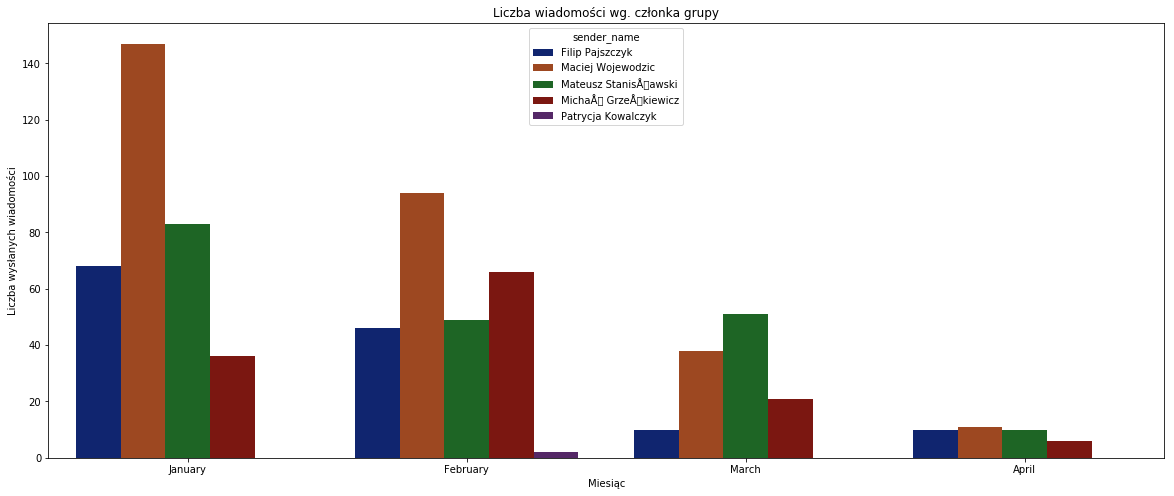

In [42]:
plt.figure(figsize=(20,8))
sns.barplot(data=year_mont, x = 'month_name', y='content', hue='sender_name',palette='dark')
plt.xlabel('Miesiąc')
plt.ylabel('Liczba wysłanych wiadomości')
plt.title('Liczba wiadomości wg. członka grupy')

In [52]:
#analiza konwersacji instagram
path = "Instagram/messages.json"
with open(path) as file:
    chat_history = json.load(file)
    
messages = pd.DataFrame(chat_history[0]['conversation'])

messages['date'] = messages['created_at'].apply(get_date)
messages['date'] = messages['date'].apply(to_string)
messages['date'] = messages['date'].apply(to_date)
messages['month'] = messages['date'].apply(get_month)
messages['year'] = messages['date'].apply(get_year)
messages['message'] = messages['text'].apply(to_string)

nltk.download('vader_lexicon')
sentiment_analyzer = SentimentIntensityAnalyzer()

messages['sentiment'] = messages['message'].apply(get_polarity)
year_month = messages.groupby(['year','month','sender']).mean().reset_index()
year_month['period'] = year_month['month'].astype(str) + '_'  + year_month['year'].astype(str)
year_month['tworca_wiadomosci'] = year_month['sender'].apply(replacer)
j = year_month[year_month['sender'] == '']['sentiment']
m = year_month[year_month['sender'] == '']['sentiment']

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/arkonei/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Text(0,0.5,'Sentiment')

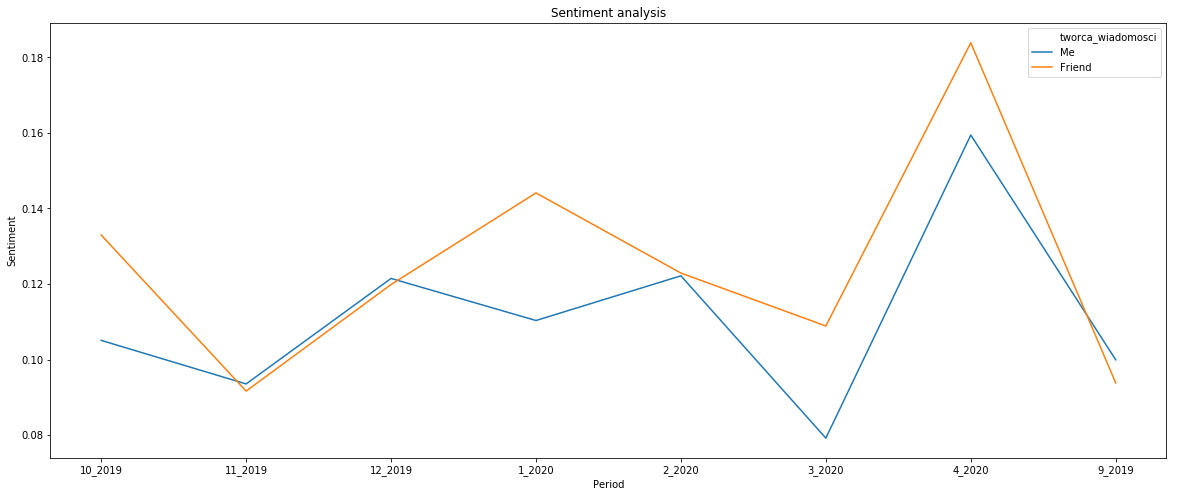

In [54]:
plt.figure(figsize=(20,8))
sns.lineplot(x = 'period', y = 'sentiment', data= year_month, hue='tworca_wiadomosci')
plt.title('Sentiment analysis')
plt.xlabel('Period')
plt.ylabel('Sentiment')

In [58]:
list_of_messages = messages['message'].tolist()
empty_string = ""
for message in list_of_messages:
    empty_string = empty_string + message + " "

(-0.5, 399.5, 199.5, -0.5)

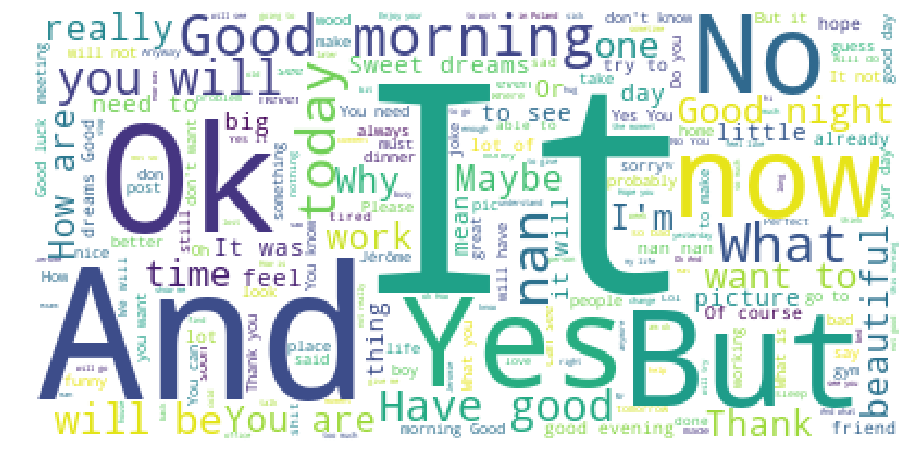

In [62]:
plt.figure(figsize=(20,8))
cloud = WordCloud(background_color='white').generate(empty_string)
plt.imshow(cloud)
plt.axis("off")

In [65]:
#analiza danych spotify
path = "Spotify/SearchQueries.json"
path2 = "Spotify/StreamingHistory0.json"
path3 = "Spotify/YourLibrary.json"
with open(path) as file:
    search = json.load(file)
    
df = pd.DataFrame(search)
df['date'] = df['searchTime'].apply(get_date)
df['date'] = df['date'].apply(to_date)
number_of_searches = df.groupby('date').size()
number_of_searches = number_of_searches.rename('searchNumber').reset_index()
number_of_searches = number_of_searches.set_index('date')
number_of_searches.head()
df['month'] = df['date'].apply(get_month)
number_of_searches = df.groupby('date').size()
number_of_searches = number_of_searches.rename('searchNumber').reset_index()
number_of_searches = number_of_searches.set_index('date')


Text(0.5,1,'Liczba wyszukiwań wg. dnia')

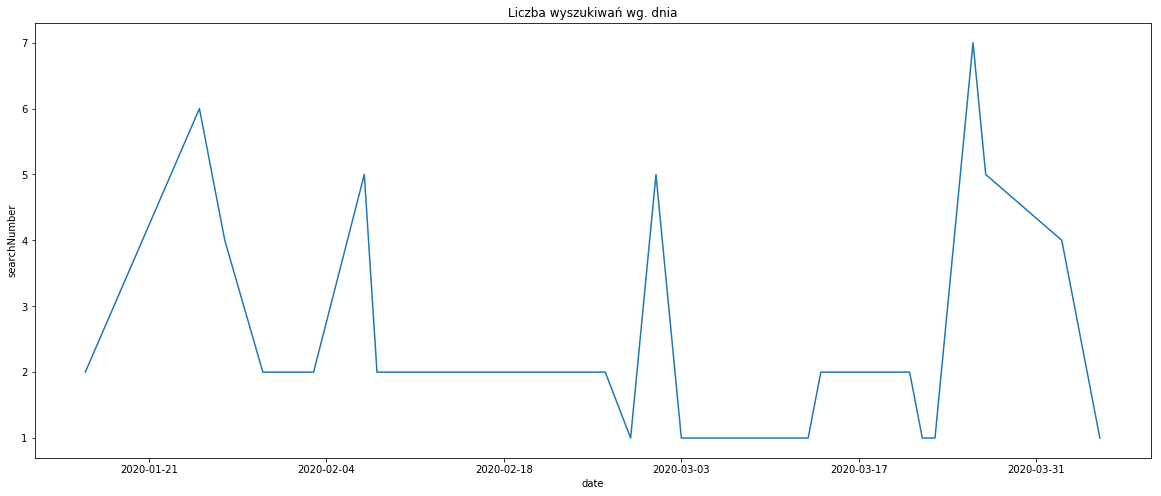

In [66]:
plt.figure(figsize=(20,8))
g = sns.lineplot(x = number_of_searches.index, y = 'searchNumber', data = number_of_searches)
plt.title('Liczba wyszukiwań wg. dnia')

In [80]:
with open(path2) as file:
    streaming = json.load(file)
streaming = pd.DataFrame(streaming)
streaming['date'] = streaming['endTime'].apply(get_date)
#streaming['date'] = streaming['endTime'].apply(date_format)
streaming['date'] = streaming['date'].apply(to_date)
streaming['month'] = streaming['date'].apply(get_month)
streaming_time = streaming.groupby('artistName').sum()
streaming_time['hours'] = streaming_time['msPlayed'].apply(convert_from_ms)
streaming_time = streaming_time.sort_values(by='hours',ascending=False)
top_10 = streaming_time.head(10)

streaming_track = streaming.groupby('trackName').sum()
streaming_track['hours'] = streaming_track['msPlayed'].apply(convert_from_ms)
streaming_track = streaming_track.sort_values(by='hours',ascending=False)
top_10_tracks = streaming_track.head(10)


[Text(0,0,'PRO8L3M'),
 Text(0,0,'Surfaces'),
 Text(0,0,'Kacperczyk'),
 Text(0,0,'The Weeknd'),
 Text(0,0,'Billie Eilish'),
 Text(0,0,'Michael Kiwanuka'),
 Text(0,0,'Harry Styles'),
 Text(0,0,'Kwiat Jabłoni'),
 Text(0,0,'Ed Sheeran'),
 Text(0,0,'Mata')]

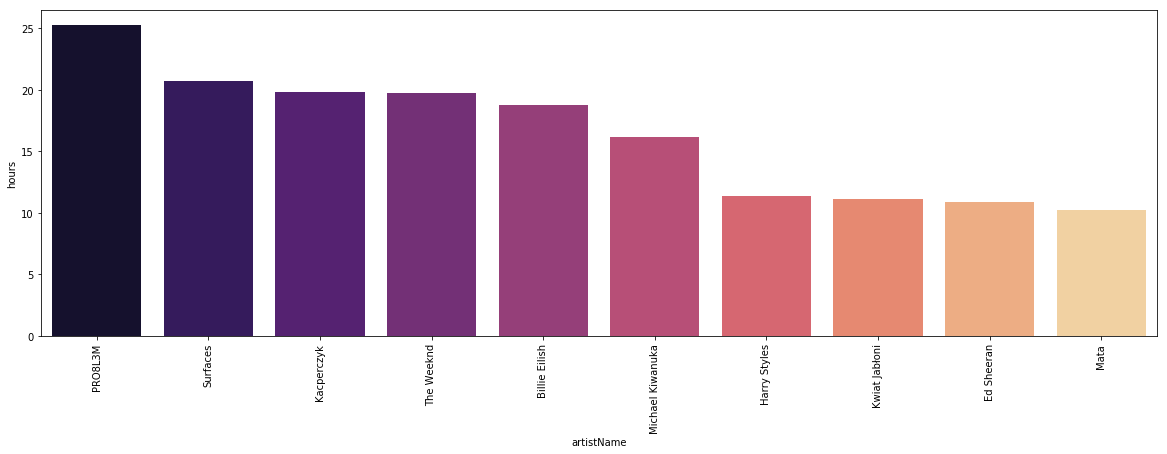

In [81]:
plt.figure(figsize=(20,6))
g = sns.barplot(x = top_10.index ,y = 'hours', data = top_10, palette='magma')
g.set_xticklabels(top_10.index, rotation=90)

[Text(0,0,'bad guy'),
 Text(0,0,'everything i wanted'),
 Text(0,0,'Falling'),
 Text(0,0,'Memories'),
 Text(0,0,'Dance Monkey'),
 Text(0,0,'Blinding Lights'),
 Text(0,0,'Circles'),
 Text(0,0,'Someone You Loved'),
 Text(0,0,"Don't Start Now"),
 Text(0,0,'Blask')]

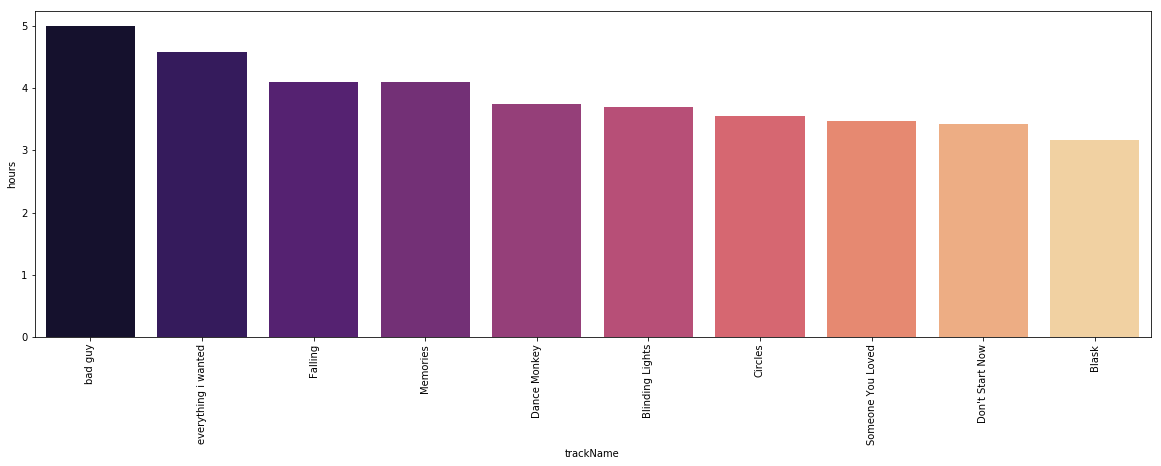

In [82]:
plt.figure(figsize=(20,6))
g = sns.barplot(x = top_10_tracks.index ,y = 'hours', data = top_10_tracks, palette='magma')
g.set_xticklabels(top_10_tracks.index, rotation=90)

In [112]:
mbank = pd.read_csv('Activities/mBank.csv',sep=';')
mbank['Data operacji'] = mbank['Data operacji'].astype(str)
mbank = mbank.dropna()
mbank['date'] = mbank['Data operacji'].apply(to_date2)
mbank['date'] = mbank['date'].apply(date_format)
mbank['date'] = mbank['date'].apply(to_date)
mbank['month'] = mbank['date'].apply(get_month)
mbank = mbank[mbank['month'] == 3]

latitude = [52.226573,0,52.386229,52.404537,52.424490,52.424490,0,52.446900,52.424490,52.424490,0,52.237847,0,0,52.424490,52.424490,
           0,0,52.291711,0,0,0,0,52.424490,52.424490,0,0,52.411979,52.424490,52.231675,52.424490,0,52.421229,0,0,0,0,0]

longitude = [17.285682,0,16.910976,16.930093, 16.989411, 16.989411,0, 16.947648,16.989411,16.989411,0, 17.275307,0,0,16.989411,16.989411,
            0,0, 17.361582,0,0,0,0,16.989411,16.989411,0,0, 16.934634,16.989411, 17.270383,16.989411,0, 16.969652,0,0,0,0,0]

mbank['latitude'] = latitude
mbank['longitude'] = longitude

geo_plot = mbank[mbank['latitude']!=0]

latitude_list = [52.226573,52.386229,52.404537,52.424490,52.424490,52.446900,52.424490,52.424490,52.237847,52.424490,52.424490,
           52.291711,52.424490,52.424490,52.411979,52.424490,52.231675,52.424490,52.421229]

longitude_list = [17.285682,16.910976,16.930093, 16.989411, 16.989411,16.947648,16.989411,16.989411,17.275307,16.989411,16.989411,
            17.361582,16.989411,16.989411,16.934634,16.989411, 17.270383,16.989411,16.969652]
gmap = gmplot.GoogleMapPlotter(52.425798, 17.089696, 12,apikey="")
gmap.scatter(latitude_list,longitude_list, size = 50, marker = True)
gmap.draw( "map21.html" )
gmap.scatter(latitude_list,longitude_list, '# FF0000', size = 40, marker = True)

mbank_wydatki = mbank['Kwota'].tolist()

cols_to_change = ['Kwota']
for col in cols_to_change:
    mbank[col] = mbank[col].str.replace('[,]', '.')
    
cols_to_change = ['Kwota']

for col in cols_to_change:
    mbank[col] = mbank[col].str.replace(' ', '')
    
mbank_wydatki = mbank['Kwota'].tolist()
[float(i) for i in mbank_wydatki]
mbank['Kwota'].astype(float)

mbank_wydatki = mbank['Kwota'].tolist()
[float(i) for i in mbank_wydatki]

mbank['Kwota'] = mbank['Kwota'].astype(float)
mbank_grouped = mbank.groupby(['Opis operacji']).sum()
mbank_wydatki = mbank_grouped.drop(['latitude','month','longitude'],axis=1)

In [115]:
s = mbank_wydatki.style.applymap(color_negative_red)
s

,Kwota
Opis operacji,
BLIK ZAKUP E-COMMERCE,-358.57
PRZELEW ZEWN TRZNY PRZYCHODZ•CY,2071
PRZELEW ZEWN TRZNY WYCHODZ•CY,-800
WYP£ATA W BANKOMACIE,-1000
ZAKUP PRZY UĮYCIU KARTY,-711.42


[mapa](Users/arkonei/Desktop/map21.html)

In [96]:
%time df = parse_json(pd.read_json("Activities/Historia lokalizacji.json"))

CPU times: user 34.8 s, sys: 1.25 s, total: 36.1 s
Wall time: 35.7 s


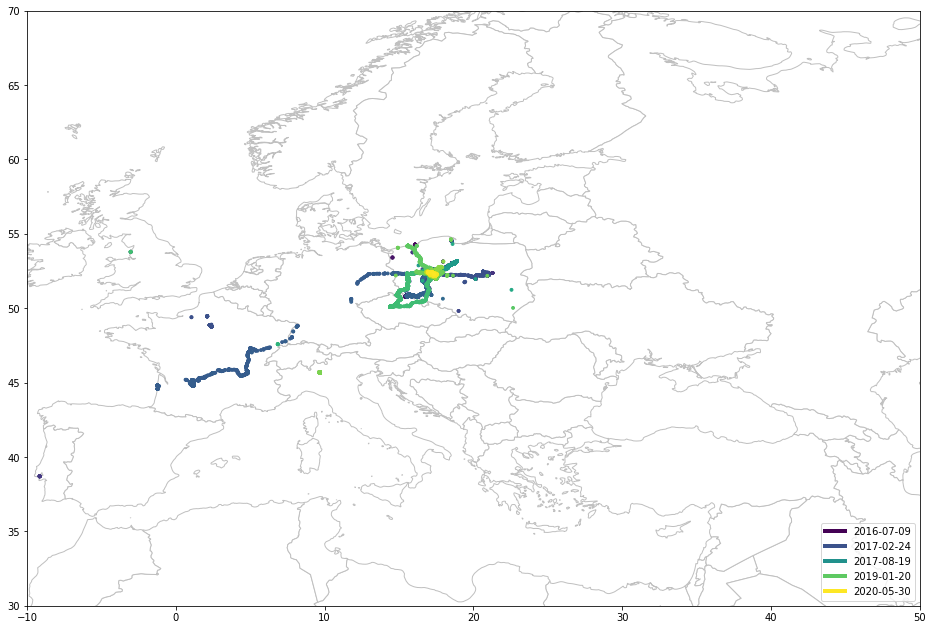

In [97]:
draw_map(df, sg.box(-10, 30, 50, 70))

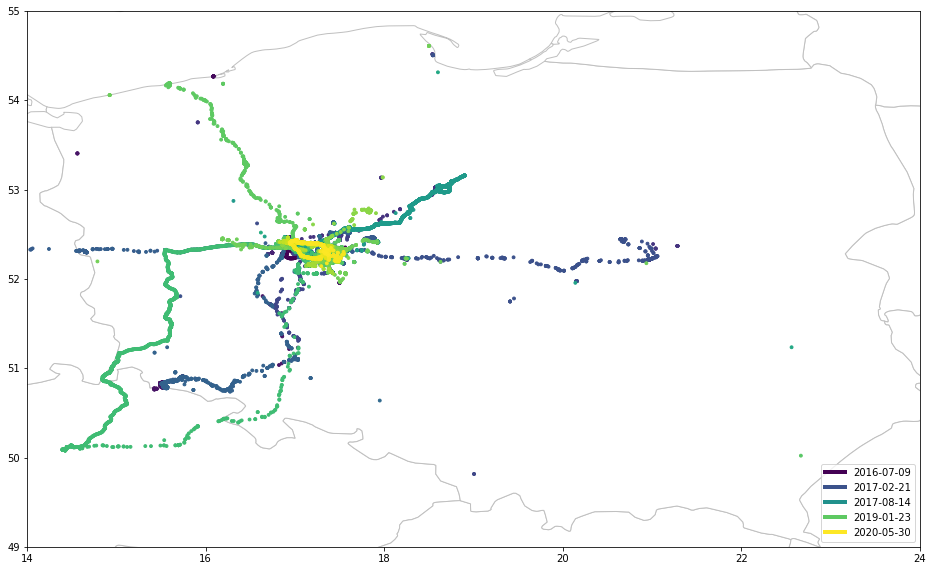

In [98]:
draw_map(df, sg.box(14, 49, 24, 55))

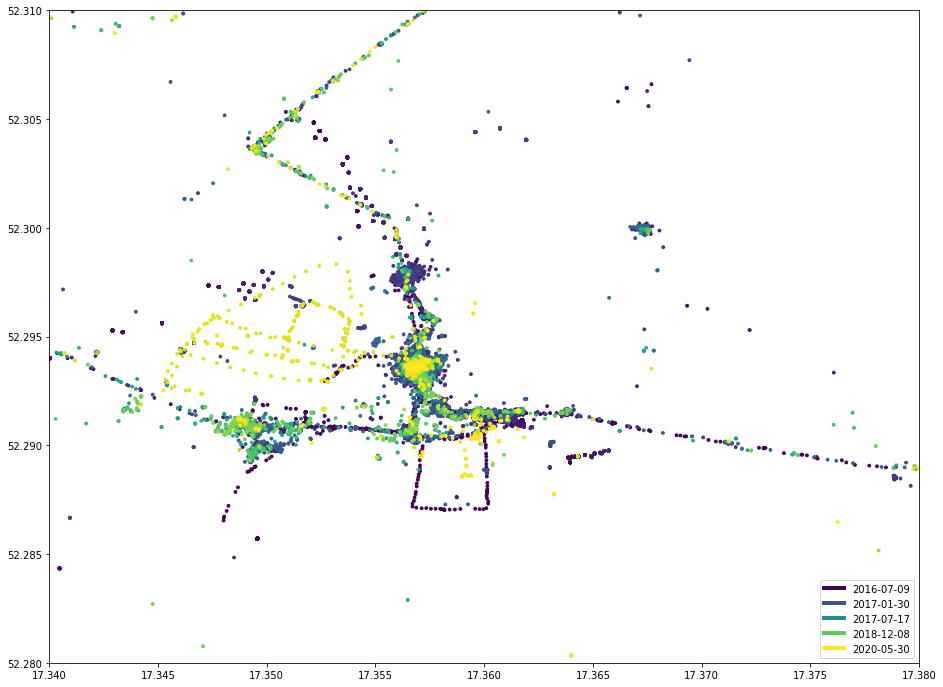

In [105]:
draw_map(df, sg.box(17.34, 52.28, 17.38, 52.31))

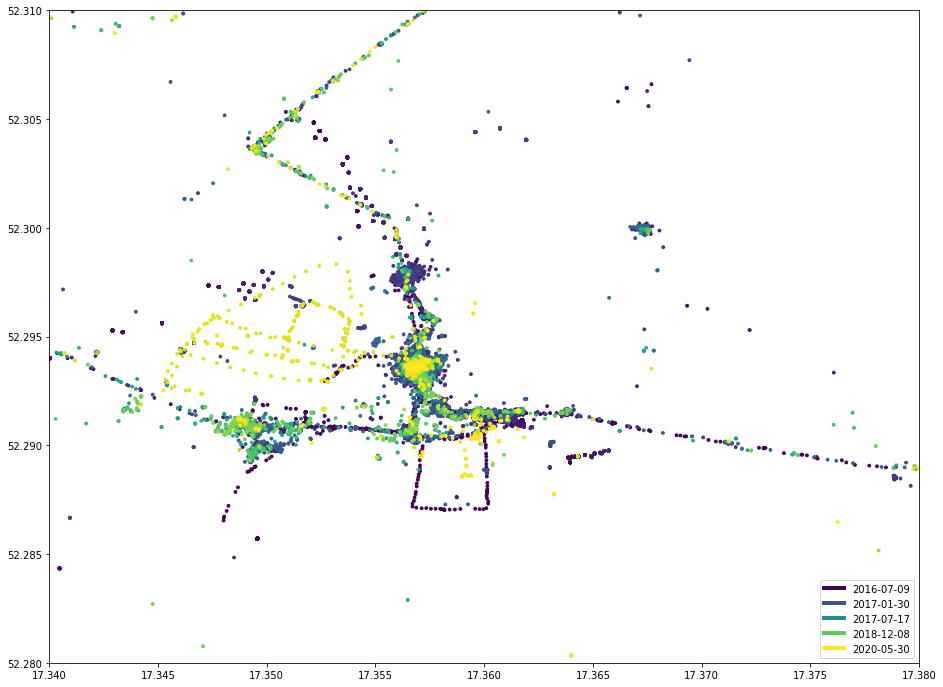

In [100]:
draw_map(df, sg.box(17.34, 52.28, 17.38, 52.31))

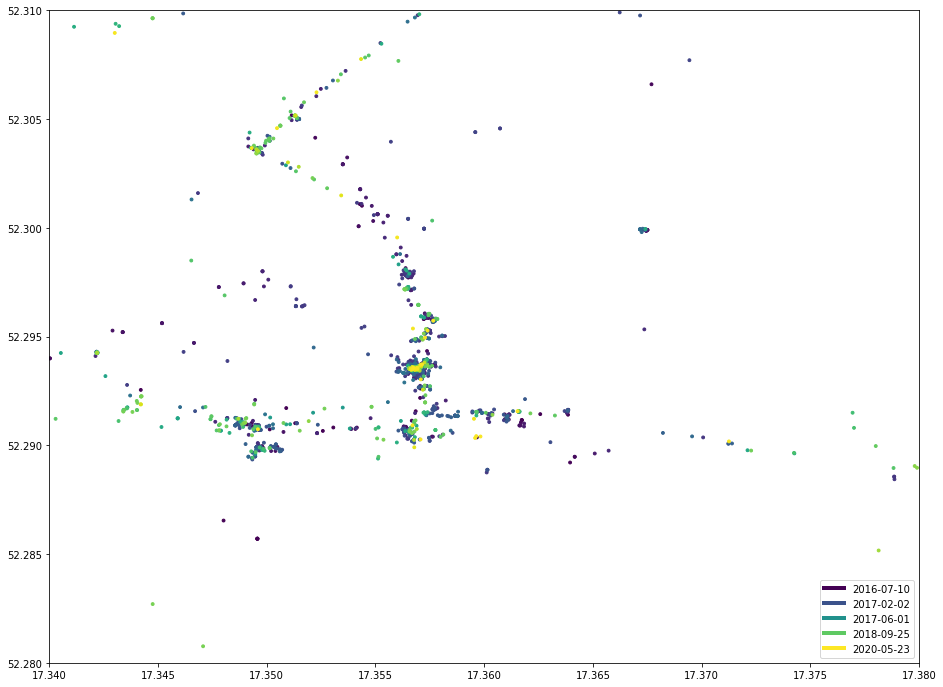

In [103]:
draw_map(df[df.activity == 'IN_VEHICLE'], sg.box(17.34, 52.28, 17.38, 52.31))

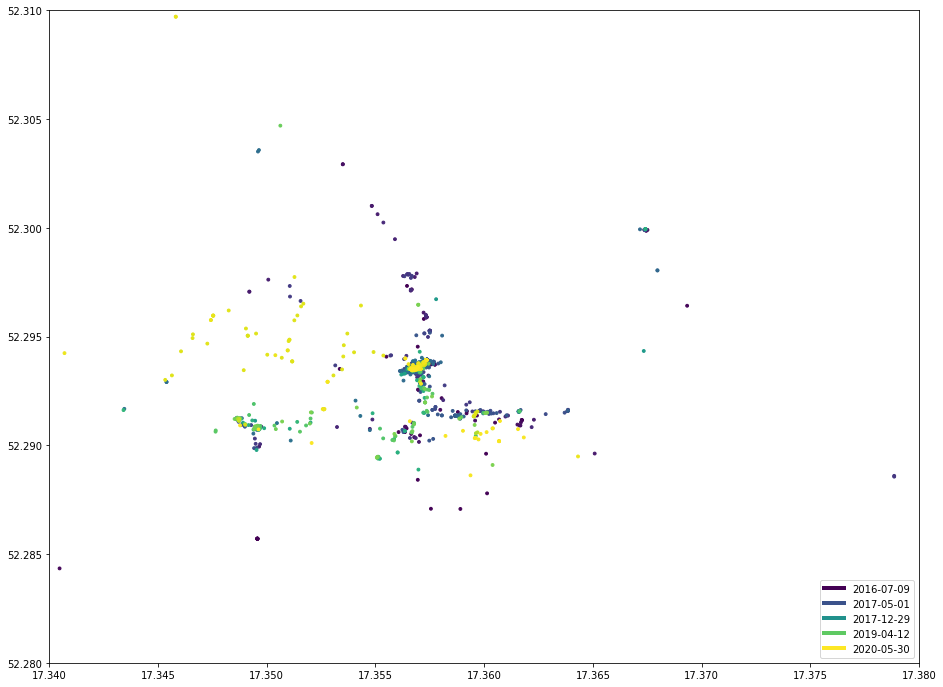

In [104]:
draw_map(df[df.activity == 'ON_FOOT'],  sg.box(17.34, 52.28, 17.38, 52.31))